In [1]:
import pandas as pd
import numpy as np
from scipy.stats import mode

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

# import wget
import pickle

In [204]:
from skimage import io

In [3]:
sns.set()

In [2]:
train_data = pd.read_csv('data/train.csv')

In [3]:
test_data = pd.read_csv('data/test.csv')

In [214]:
%%time
import requests

url = 'https://images.gr-assets.com/books/1445900480l/27282801.jpg'
r = requests.get('https://images.gr-assets.com/books/1445900480l/27282801.jpg')

image_name = url.split('/')[-1]
with open(f'images/{image_name}', 'wb') as file:
    file.write(r.content)


CPU times: user 16.3 ms, sys: 61 µs, total: 16.4 ms
Wall time: 145 ms


In [5]:
%%time
import requests

for idx,url in enumerate(train_data['book_image_url']):
    try:
        r = requests.get(url)
        with open(f'images/{idx}.jpg', 'wb') as file:
            file.write(r.content)
    except:
        continue

CPU times: user 15min 8s, sys: 57.2 s, total: 16min 5s
Wall time: 6h 7min


In [5]:
train_data.head()

,id,book_title,book_image_url,book_desc,book_genre,book_authors,book_format,book_pages,book_review_count,book_rating_count,book_rating
0,0,Forastera,https://images.gr-assets.com/books/1500683049l...,"Recién acabada la Segunda Guerra Mundial, una ...",Historical|Historical Fiction|Romance|Fantasy|...,Diana Gabaldon|Carmen Bordeu,Kindle Edition,768 pages,40197,668892,4.22
1,1,Writing about Magic,https://images.gr-assets.com/books/1445900480l...,Do you write fantasy fiction? This book is a r...,Language|Writing|Nonfiction,Rayne Hall,Paperback,180 pages,27,126,3.95
2,2,The Stress of Her Regard,https://images.gr-assets.com/books/1503059955l...,When Michael Crawford discovers his bride brut...,Fantasy|Horror|Paranormal|Vampires|Historical|...,Tim Powers,Paperback,470 pages,331,3626,3.79
3,3,The Horrors and Absurdities of Religion,https://images.gr-assets.com/books/1409779869l...,"A fascinating examination of ethics, religion ...",Philosophy|Religion|Nonfiction|Classics,Arthur Schopenhauer,Paperback,106 pages,28,371,3.85
4,4,Three Tales,https://images.gr-assets.com/books/1311645483l...,"First published in 1877, these three stories a...",Fiction|Short Stories|Classics|Cultural|France...,Gustave Flaubert|Roger Whitehouse|Geoffrey Wall,Paperback,110 pages,250,4331,3.72


In [6]:
train_data.iloc[1,2]

'https://images.gr-assets.com/books/1445900480l/27282801.jpg'

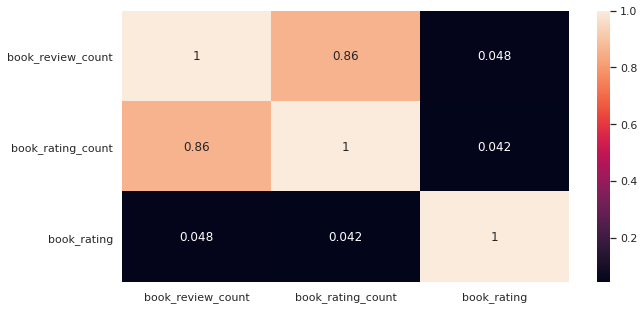

In [7]:
plt.figure(figsize=(10, 5))
sns.heatmap(train_data.drop(columns='id').corr(), annot=True)

plt.yticks(rotation=0);

In [245]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 40000 non-null  int64  
 1   book_title         40000 non-null  object 
 2   book_image_url     39608 non-null  object 
 3   book_desc          40000 non-null  object 
 4   book_genre         37551 non-null  object 
 5   book_authors       40000 non-null  object 
 6   book_format        39080 non-null  object 
 7   book_pages         38141 non-null  object 
 8   book_review_count  40000 non-null  int64  
 9   book_rating_count  40000 non-null  int64  
 10  book_rating        40000 non-null  float64
dtypes: float64(1), int64(3), object(7)
memory usage: 3.4+ MB


In [246]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3020 entries, 0 to 3019
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 3020 non-null   int64 
 1   book_title         3020 non-null   object
 2   book_image_url     3020 non-null   object
 3   book_desc          3020 non-null   object
 4   book_genre         3020 non-null   object
 5   book_authors       3020 non-null   object
 6   book_format        3020 non-null   object
 7   book_pages         3020 non-null   object
 8   book_review_count  3020 non-null   int64 
 9   book_rating_count  3020 non-null   int64 
dtypes: int64(3), object(7)
memory usage: 236.1+ KB


## book_count

In [128]:
def get_dict_authors():
    d = {}
    for line in train_data['book_authors'].values:
        for author in np.unique(line.split('|')):
            d.setdefault(author, 0)
            d[author] += 1
    
    return d

dict_authors = get_dict_authors()

In [129]:
def get_book_count(s):
    arr = []
    for author in np.unique(s.split('|')):
        arr.append(dict_authors.get(author, 1))
    
    return max(arr)
        

In [130]:
def make_book_count_categories(count):
    categories = {1:1,2:2,3:3,4:4}
    if count>3:
        return categories[4]
    else:
        return categories[count]

In [131]:
train_data['book_count'] = train_data['book_authors'].map(get_book_count)
train_data['book_count'] = train_data['book_count'].apply(lambda x: make_book_count_categories(x))


In [132]:
test_data['book_count'] = test_data['book_authors'].map(get_book_count)
test_data['book_count'] = test_data['book_count'].apply(lambda x: make_book_count_categories(x))

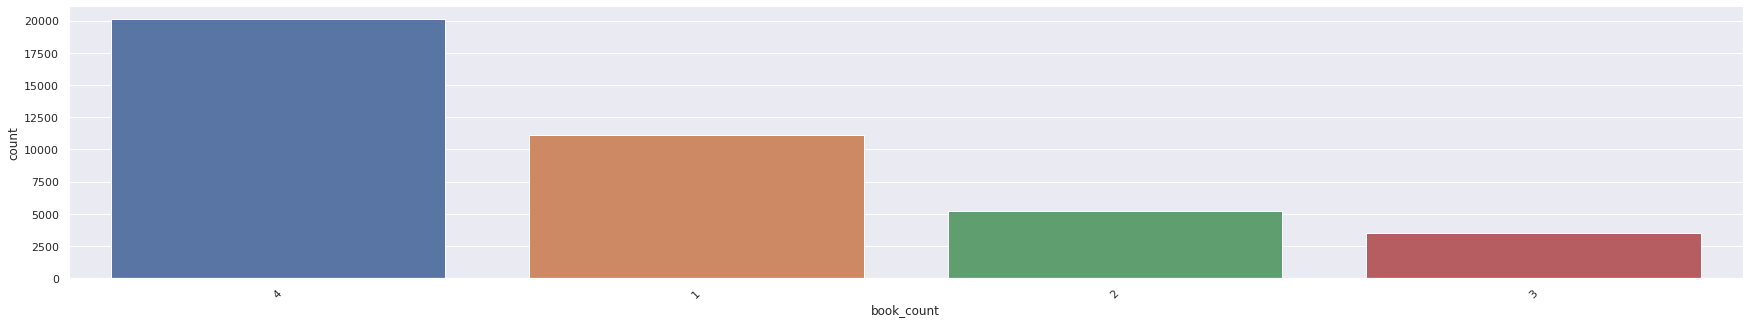

In [107]:
plt.figure(figsize=(30, 5))
sns.countplot(x='book_count', data=train_data, order=train_data['book_count'].value_counts().index)
plt.xticks(rotation=45);

/home/dmytro/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 21336 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/dmytro/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 34892 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/dmytro/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 26412 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/dmytro/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 21336 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/dmytro/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 34892 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/dmytro/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201

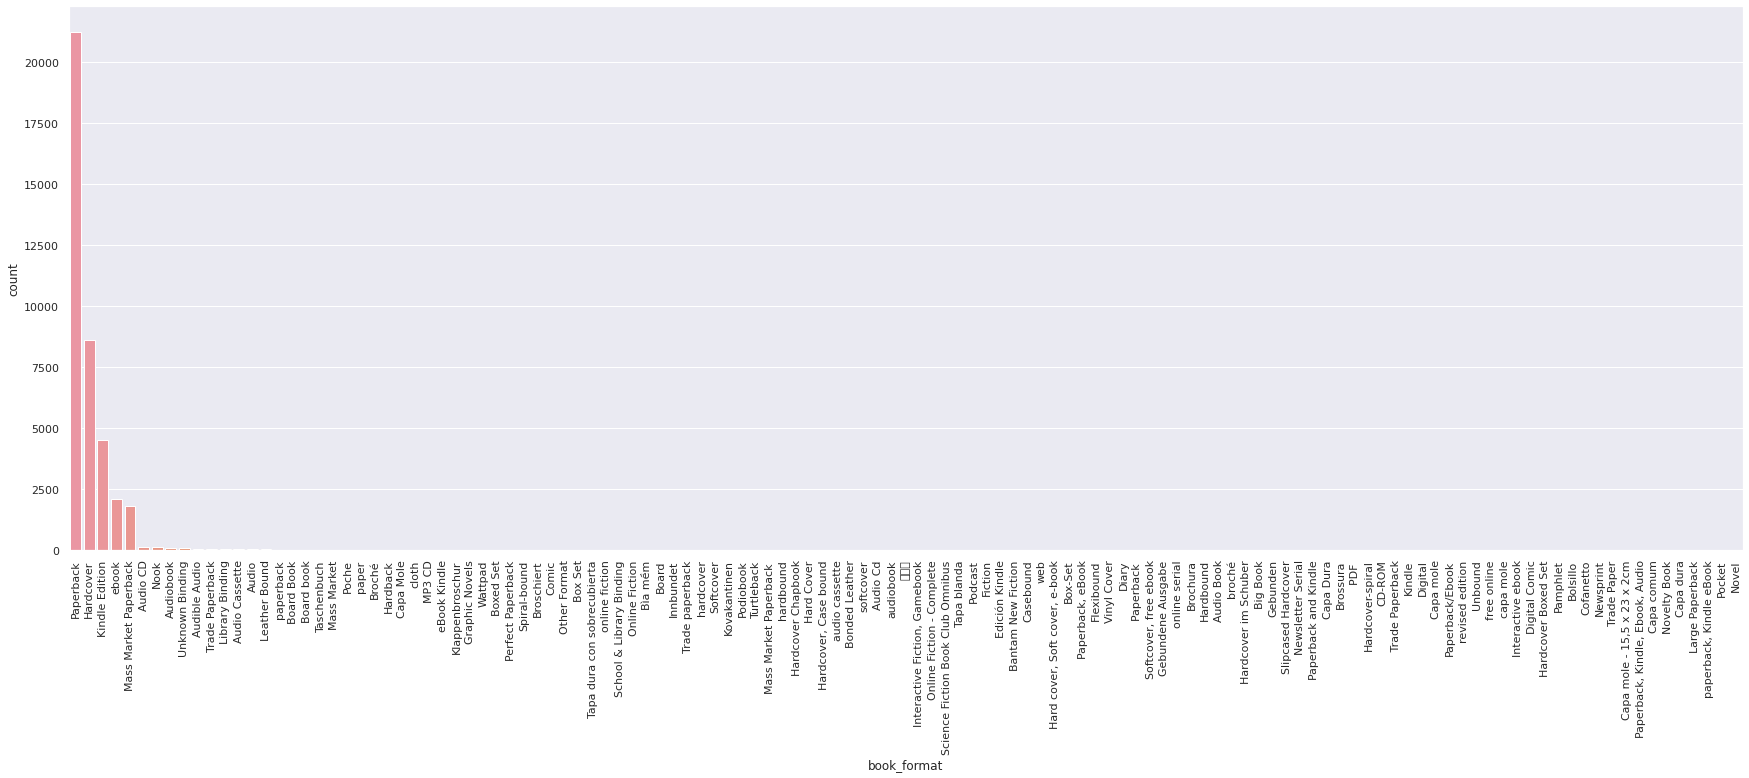

In [111]:
plt.figure(figsize=(30, 10))
sns.countplot(x='book_format', data=train_data, order=train_data['book_format'].value_counts().index)
plt.xticks(rotation=90);

## book_format

In [181]:
def get_book_format(s):
    s = s.str.lower()
    if s in ['paperback', 'hardcover', 'mass market paperback', 'trade paperback', 'mass market']:
        return 1
    elif s in ['Kindle Edition', 'ebook', 'Nook', 'eBook Kindle']:
        return 2
    elif s in ['Audio CD', 'Audiobook', 'Audible Audio', 'Audio','Audio Cassette']:
        return 3
    else:
        return 4
    

In [113]:
train_data['book_format'].value_counts().head(50)

Paperback                      21209
Hardcover                       8607
Kindle Edition                  4492
ebook                           2079
Mass Market Paperback           1814
Audio CD                         136
Nook                             114
Audiobook                         92
Unknown Binding                   71
Audible Audio                     55
Trade Paperback                   43
Library Binding                   35
Audio Cassette                    29
Audio                             21
Leather Bound                     21
paperback                         17
Board Book                        16
Board book                        13
Taschenbuch                       12
Mass Market                       11
Poche                             10
paper                              9
Broché                             8
Hardback                           7
Capa Mole                          7
cloth                              6
MP3 CD                             6
e

In [182]:
train_data['book_format'] = train_data['book_format'].map(get_book_format)
test_data['book_format'] = test_data['book_format'].map(get_book_format)

<AxesSubplot:>

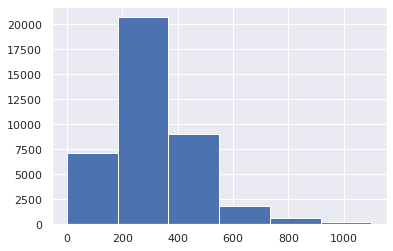

In [168]:
train_data[train_data['book_pages']<1100]['book_pages'].hist(bins=6)

In [170]:
def make_book_pages(pages):
    if pages<200:
        return 1
    elif pages<400 and pages>=200:
        return 2
    elif pages<600 and pages>=400:
        return 3
    else:
        return 4

In [171]:
train_data['book_pages'] = train_data['book_pages'].apply(lambda x: make_book_pages(x))
test_data['book_pages'] = test_data['book_pages'].apply(lambda x: make_book_pages(x))

In [183]:
train_data['count_feature'] = train_data['book_rating_count']/train_data['book_review_count']
test_data['count_feature'] = test_data['book_rating_count']/test_data['book_review_count']

In [184]:
train_data.head()

,id,book_title,book_image_url,book_desc,book_genre,book_authors,book_format,book_pages,book_review_count,book_rating_count,book_rating,count_feature
0,0,Forastera,https://images.gr-assets.com/books/1500683049l...,"Recién acabada la Segunda Guerra Mundial, una ...",Historical|Historical Fiction|Romance|Fantasy|...,Diana Gabaldon|Carmen Bordeu,2,768 pages,40197,668892,4.22,16.640346
1,1,Writing about Magic,https://images.gr-assets.com/books/1445900480l...,Do you write fantasy fiction? This book is a r...,Language|Writing|Nonfiction,Rayne Hall,1,180 pages,27,126,3.95,4.666667
2,2,The Stress of Her Regard,https://images.gr-assets.com/books/1503059955l...,When Michael Crawford discovers his bride brut...,Fantasy|Horror|Paranormal|Vampires|Historical|...,Tim Powers,1,470 pages,331,3626,3.79,10.954683
3,3,The Horrors and Absurdities of Religion,https://images.gr-assets.com/books/1409779869l...,"A fascinating examination of ethics, religion ...",Philosophy|Religion|Nonfiction|Classics,Arthur Schopenhauer,1,106 pages,28,371,3.85,13.250000
4,4,Three Tales,https://images.gr-assets.com/books/1311645483l...,"First published in 1877, these three stories a...",Fiction|Short Stories|Classics|Cultural|France...,Gustave Flaubert|Roger Whitehouse|Geoffrey Wall,1,110 pages,250,4331,3.72,17.324000


## book_pages

In [185]:
train_data['book_pages'] = pd.to_numeric(train_data['book_pages'].str.extract(r'(\d+)', expand=False), errors='coerce')
train_data['book_pages'] = train_data['book_pages'].fillna(320)

In [186]:
test_data['book_pages'] = pd.to_numeric(test_data['book_pages'].str.extract(r'(\d+)', expand=False), errors='coerce')
test_data['book_pages'] = test_data['book_pages'].fillna(320)

In [205]:
def image_size(url):
    try:
        height, width = io.imread(url).shape[:2]
        return [height, width]
    except Exception:
        return [np.nan, np.nan]

In [206]:
train_data[['book_height', 'book_width']] = pd.DataFrame(train_data['book_image_url'].map(image_size).values.tolist())
test_data[['book_height', 'book_width']] = pd.DataFrame(test_data['book_image_url'].map(image_size).values.tolist())
%%time

/home/dmytro/anaconda3/lib/python3.8/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


KeyboardInterrupt: 

## train_test_split

In [199]:
X = train_data.drop(columns=['book_rating','book_review_count'])
y = train_data['book_rating']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [173]:
test_data.head()

,id,book_title,book_image_url,book_desc,book_genre,book_authors,book_format,book_pages,book_review_count,book_rating_count,book_count,count_feature
0,0,The Paper Wasp,https://i.gr-assets.com/images/S/compressed.ph...,An electrifying debut novel from the acclaimed...,Fiction|Contemporary|Thriller|Thriller|Mystery...,Lauren Acampora,1,2,415,1587,1,3.824096
1,1,The Old Success,https://i.gr-assets.com/images/S/compressed.ph...,When the body of a French woman washes up on a...,Mystery|Fiction|European Literature|British Li...,Martha Grimes,1,2,409,2777,4,6.789731
2,2,The Berlin Girl,https://i.gr-assets.com/images/S/compressed.ph...,From the bestselling author of The German Midw...,Historical|Historical Fiction|Fiction|War|Worl...,Mandy Robotham,1,3,270,1413,1,5.233333
3,3,Bringing Down the Duke,https://i.gr-assets.com/images/S/compressed.ph...,One of Publishers Weekly's Most Anticipated Fa...,Romance|Historical|Historical Fiction|Romance|...,Evie Dunmore,1,2,4926,32404,1,6.578157
4,4,Horse Crazy: Girls and the Lives of Horses,https://i.gr-assets.com/images/S/compressed.ph...,Horse Crazy explores the meaning behind the lo...,Nonfiction|Psychology,Jean O'Malley Halley,1,2,7,11,1,1.571429


In [188]:
vectorizer = TfidfVectorizer(ngram_range=(1, 1), max_df=1.0, min_df=0.2)
X_train_vectorized = vectorizer.fit_transform(X_train['book_desc'])
X_valid_vectorized = vectorizer.transform(X_valid['book_desc'])

X_test_vectorized = vectorizer.transform(test_data['book_desc'])

In [146]:
X_train.head()

,id,book_title,book_image_url,book_desc,book_genre,book_authors,book_format,book_pages,book_count,count_feature
14307,14307,Indigo Blue,https://images.gr-assets.com/books/1463825508l...,Rutsu Nakagawa est une jeune écrivaine. Elle s...,Sequential Art|Manga|Sequential Art|Comics|Lgb...,Ebine Yamaji,1,198.0,1,12.600000
17812,17812,Helga's Diary: A Young Girl's Account of Life ...,https://images.gr-assets.com/books/1337221937l...,"In 1939, Helga Weiss was an eleven-year-old Je...",Nonfiction|World War II|Holocaust|History|Biog...,Helga Weiss,1,208.0,1,8.053333
11020,11020,Kotona maailmankaikkeudessa,https://images.gr-assets.com/books/1253175798l...,Kotona maailmankaikkeudessa tutkii elämän mahd...,Nonfiction|Science|European Literature|Finnish...,Esko Valtaoja,1,333.0,1,35.461538
15158,15158,Siege,https://images.gr-assets.com/books/1350545061l...,1453. For over a thousand years the walls of C...,Historical|Historical Fiction|Historical|War,Jack Hight,1,416.0,1,7.150000
24990,24990,The Fields,https://images.gr-assets.com/books/1388227876l...,Conrad Richter's trilogy of novels The Trees (...,Historical|Historical Fiction|Fiction|Classics...,Conrad Richter,1,169.0,3,11.111111


In [ ]:
X_train = np.concatenate([X_train_vectorized.toarray(), X_train[['book_height', 'book_width', 'book_pages', 'book_format', 'book_rating_count']]], axis=1)
X_valid = np.concatenate([X_valid_vectorized.toarray(), X_valid[['book_height', 'book_width', 'book_pages', 'book_format', 'book_rating_count']]], axis=1)

X_test = np.concatenate([X_test_vectorized.toarray(), test_data[['book_height', 'book_width', 'book_pages', 'book_format', 'book_rating_count']]], axis=1)

## model

In [ ]:
clf_xgb = XGBRegressor(max_depth=4, learning_rate=0.05, n_estimators=500, n_jobs=-1)
clf_xgb.fit(X_train, y_train)
y_pred = clf_xgb.predict(X_valid)
%%time

In [ ]:
mean_squared_error(y_valid, y_pred, squared=False)

In [270]:
pickle.dump(clf_xgb, open('model.pickle', 'wb'))

In [177]:
param_xgb = {'learning_rate': [0.01, 0.05, 0.1], 'max_depth': [2, 4, 8],
              'n_estimators': [100, 200, 500]}

In [178]:
grid_xgb = GridSearchCV(clf_xgb, param_xgb, scoring='neg_root_mean_squared_error', cv=5)
grid_xgb.fit(X_train, y_train)
grid_xgb.best_params_

KeyboardInterrupt: 

## submission

In [ ]:
submission = pd.DataFrame({'id': test_data['id'], 'book_rating': clf_xgb.predict(X_test)})
submission

In [ ]:
submission.to_csv('data/submission.csv', index=False)